##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Text classification with preprocessed text: Movie reviews

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook classifies movie reviews as *positive* or *negative* using the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

We'll use the [IMDB dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.

This notebook uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow. For a more advanced text classification tutorial using `tf.keras`, see the [MLCC Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification/).

## Setup

In [3]:
!pip install -q tf-nightly
import tensorflow as tf

In [4]:
from tensorflow import keras

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np

print(tf.__version__)

2.3.0-dev20200513


<a id="download"></a>

## Download the IMDB dataset

The IMDB movie reviews dataset comes packaged in `tfds`. It has already been preprocessed so that the reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary.

The following code downloads the IMDB dataset to your machine (or uses a cached copy if you've already downloaded it):

To encode your own text see the [Loading text tutorial](../load_data/text.ipynb)

In [5]:
(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)

Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteDTN2U6/imdb_reviews-train.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteDTN2U6/imdb_reviews-test.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteDTN2U6/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /home/kbuilder/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


<a id="encoder"></a>

## Try the encoder

 The dataset `info` includes the text encoder (a `tfds.features.text.SubwordTextEncoder`).

In [6]:
encoder = info.features['text'].encoder

In [7]:
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


This text encoder will reversibly encode any string:

In [8]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

assert original_string == sample_string

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


The encoder encodes the string by breaking it into subwords or characters if the word is not in its dictionary. So the more a string resembles the dataset, the shorter the encoded representation will be.

In [9]:
for ts in encoded_string:
  print ('{} ----> {}'.format(ts, encoder.decode([ts])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## Explore the data

Let's take a moment to understand the format of the data. The dataset comes preprocessed: each example is an array of integers representing the words of the movie review. 

The text of reviews have been converted to integers, where each integer represents a specific word-piece in the dictionary. 

Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

Here's what the first review looks like:

In [10]:
for train_example, train_label in train_data.take(1):
  print('Encoded text:', train_example[:10].numpy())
  print('Label:', train_label.numpy())

Encoded text: [  62   18   41  604  927   65    3  644 7968   21]
Label: 0


The `info` structure contains the encoder/decoder. The encoder can be used to recover the original text:

In [11]:
encoder.decode(train_example)

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

## Prepare the data for training

You will want to create batches of training data for your model. The reviews are all different lengths, so use `padded_batch` to zero pad the sequences while batching:

In [12]:
BUFFER_SIZE = 1000

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32, padded_shapes=([None],[])))

test_batches = (
    test_data
    .padded_batch(32, padded_shapes=([None],[])))

Note: As of **TensorFlow 2.2** the `padded_shapes` argument is no longer required. The default behavior is to pad all axes to the longest in the batch.

In [13]:
train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32))

test_batches = (
    test_data
    .padded_batch(32))

Each batch will have a shape of `(batch_size, sequence_length)` because the padding is dynamic each batch will have a different length:

In [14]:
for example_batch, label_batch in train_batches.take(2):
  print("Batch shape:", example_batch.shape)
  print("label shape:", label_batch.shape)
  

Batch shape: (32, 1615)
label shape: (32,)
Batch shape: (32, 1109)
label shape: (32,)


## Build the model

The neural network is created by stacking layers—this requires two main architectural decisions:

* How many layers to use in the model?
* How many *hidden units* to use for each layer?

In this example, the input data consists of an array of word-indices. The labels to predict are either 0 or 1. Let's build a "Continuous bag of words" style model for this problem:

Caution: This model doesn't use masking, so the zero-padding is used as part of the input, so the padding length may affect the output.  To fix this, see the [masking and padding guide](../../guide/keras/masking_and_padding.ipynb).

In [15]:
model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  *To learn more about embeddings, see the [word embedding tutorial](../text/word_embeddings.ipynb).*
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.
4. The last layer is densely connected with a single output node. This uses the default *linear* activation function that outputs *logits* for numerical stability. Another option is to use the *sigmoid* activation function that returns a float value between 0 and 1, representing a probability, or confidence level.

### Hidden units

The above model has two intermediate or "hidden" layers, between the input and output. The number of outputs (units, nodes, or neurons) is the dimension of the representational space for the layer. In other words, the amount of freedom the network is allowed when learning an internal representation.

If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, it makes the network more computationally expensive and may lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data. This is called *overfitting*, and we'll explore it later.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs logits (a single-unit layer with a linear activation), we'll use the `binary_crossentropy` loss function.

This isn't the only choice for a loss function, you could, for instance, choose `mean_squared_error`. But, generally, `binary_crossentropy` is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Later, when we are exploring regression problems (say, to predict the price of a house), we will see how to use another loss function called mean squared error.

Now, configure the model to use an optimizer and a loss function:

In [16]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

Train the model by passing the `Dataset` object to the model's fit function. Set the number of epochs.

In [17]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,
                    validation_steps=30)

Epoch 1/10


  1/782 [..............................] - ETA: 0s - loss: 0.6918 - accuracy: 0.4688

 11/782 [..............................] - ETA: 3s - loss: 0.6918 - accuracy: 0.4744

 22/782 [..............................] - ETA: 3s - loss: 0.6929 - accuracy: 0.4844

 32/782 [>.............................] - ETA: 3s - loss: 0.6931 - accuracy: 0.4902

 43/782 [>.............................] - ETA: 3s - loss: 0.6933 - accuracy: 0.4971

 54/782 [=>............................] - ETA: 3s - loss: 0.6930 - accuracy: 0.4919

 66/782 [=>............................] - ETA: 3s - loss: 0.6930 - accuracy: 0.4943

 78/782 [=>............................] - ETA: 3s - loss: 0.6929 - accuracy: 0.4972

 89/782 [==>...........................] - ETA: 3s - loss: 0.6928 - accuracy: 0.5004

 99/782 [==>...........................] - ETA: 3s - loss: 0.6928 - accuracy: 0.4959

111/782 [===>..........................] - ETA: 3s - loss: 0.6926 - accuracy: 0.4992

122/782 [===>..........................] - ETA: 3s - loss: 0.6925 - accuracy: 0.4944

133/782 [====>.........................] - ETA: 3s - loss: 0.6925 - accuracy: 0.4960

145/782 [====>.........................] - ETA: 2s - loss: 0.6924 - accuracy: 0.4983

157/782 [=====>........................] - ETA: 2s - loss: 0.6922 - accuracy: 0.4974

168/782 [=====>........................] - ETA: 2s - loss: 0.6921 - accuracy: 0.4965

180/782 [=====>........................] - ETA: 2s - loss: 0.6920 - accuracy: 0.4953

192/782 [======>.......................] - ETA: 2s - loss: 0.6919 - accuracy: 0.4945

203/782 [======>.......................] - ETA: 2s - loss: 0.6918 - accuracy: 0.4940

214/782 [=======>......................] - ETA: 2s - loss: 0.6916 - accuracy: 0.4940

225/782 [=======>......................] - ETA: 2s - loss: 0.6915 - accuracy: 0.4949

236/782 [========>.....................] - ETA: 2s - loss: 0.6914 - accuracy: 0.4974

247/782 [========>.....................] - ETA: 2s - loss: 0.6913 - accuracy: 0.4989

259/782 [========>.....................] - ETA: 2s - loss: 0.6911 - accuracy: 0.4989

270/782 [=========>....................] - ETA: 2s - loss: 0.6909 - accuracy: 0.4992

281/782 [=========>....................] - ETA: 2s - loss: 0.6907 - accuracy: 0.5006

292/782 [==========>...................] - ETA: 2s - loss: 0.6906 - accuracy: 0.5006

303/782 [==========>...................] - ETA: 2s - loss: 0.6905 - accuracy: 0.5001

314/782 [===========>..................] - ETA: 2s - loss: 0.6903 - accuracy: 0.4991

325/782 [===========>..................] - ETA: 2s - loss: 0.6902 - accuracy: 0.5002

337/782 [===========>..................] - ETA: 2s - loss: 0.6900 - accuracy: 0.5005

348/782 [============>.................] - ETA: 2s - loss: 0.6898 - accuracy: 0.5003

359/782 [============>.................] - ETA: 1s - loss: 0.6896 - accuracy: 0.5003

371/782 [=============>................] - ETA: 1s - loss: 0.6894 - accuracy: 0.4997

382/782 [=============>................] - ETA: 1s - loss: 0.6892 - accuracy: 0.4990

393/782 [==============>...............] - ETA: 1s - loss: 0.6891 - accuracy: 0.4994

404/782 [==============>...............] - ETA: 1s - loss: 0.6889 - accuracy: 0.4994

416/782 [==============>...............] - ETA: 1s - loss: 0.6887 - accuracy: 0.4986

427/782 [===============>..............] - ETA: 1s - loss: 0.6885 - accuracy: 0.4990

439/782 [===============>..............] - ETA: 1s - loss: 0.6884 - accuracy: 0.4988

451/782 [================>.............] - ETA: 1s - loss: 0.6881 - accuracy: 0.5000

462/782 [================>.............] - ETA: 1s - loss: 0.6880 - accuracy: 0.4998

474/782 [=================>............] - ETA: 1s - loss: 0.6877 - accuracy: 0.5005

486/782 [=================>............] - ETA: 1s - loss: 0.6876 - accuracy: 0.4999

497/782 [==================>...........] - ETA: 1s - loss: 0.6874 - accuracy: 0.5007

508/782 [==================>...........] - ETA: 1s - loss: 0.6871 - accuracy: 0.5006

521/782 [==================>...........] - ETA: 1s - loss: 0.6868 - accuracy: 0.5004

532/782 [===================>..........] - ETA: 1s - loss: 0.6865 - accuracy: 0.5013

543/782 [===================>..........] - ETA: 1s - loss: 0.6864 - accuracy: 0.5008

555/782 [====================>.........] - ETA: 1s - loss: 0.6862 - accuracy: 0.5012

566/782 [====================>.........] - ETA: 0s - loss: 0.6860 - accuracy: 0.5018

576/782 [=====================>........] - ETA: 0s - loss: 0.6859 - accuracy: 0.5016

587/782 [=====================>........] - ETA: 0s - loss: 0.6856 - accuracy: 0.5015

598/782 [=====================>........] - ETA: 0s - loss: 0.6855 - accuracy: 0.5016

609/782 [======================>.......] - ETA: 0s - loss: 0.6852 - accuracy: 0.5017

620/782 [======================>.......] - ETA: 0s - loss: 0.6849 - accuracy: 0.5010

632/782 [=======================>......] - ETA: 0s - loss: 0.6846 - accuracy: 0.4998

643/782 [=======================>......] - ETA: 0s - loss: 0.6845 - accuracy: 0.5012

654/782 [========================>.....] - ETA: 0s - loss: 0.6842 - accuracy: 0.4999

666/782 [========================>.....] - ETA: 0s - loss: 0.6838 - accuracy: 0.5008

677/782 [========================>.....] - ETA: 0s - loss: 0.6835 - accuracy: 0.5006

687/782 [=========================>....] - ETA: 0s - loss: 0.6834 - accuracy: 0.5005

699/782 [=========================>....] - ETA: 0s - loss: 0.6830 - accuracy: 0.5012

710/782 [==========================>...] - ETA: 0s - loss: 0.6826 - accuracy: 0.5013

721/782 [==========================>...] - ETA: 0s - loss: 0.6823 - accuracy: 0.5007

730/782 [===========================>..] - ETA: 0s - loss: 0.6821 - accuracy: 0.5005

742/782 [===========================>..] - ETA: 0s - loss: 0.6818 - accuracy: 0.5003

753/782 [===========================>..] - ETA: 0s - loss: 0.6815 - accuracy: 0.5007

765/782 [============================>.] - ETA: 0s - loss: 0.6812 - accuracy: 0.5006

778/782 [============================>.] - ETA: 0s - loss: 0.6809 - accuracy: 0.5014

782/782 [==============================] - 4s 5ms/step - loss: 0.6807 - accuracy: 0.5011 - val_loss: 0.6621 - val_accuracy: 0.5063


Epoch 2/10
  1/782 [..............................] - ETA: 0s - loss: 0.6604 - accuracy: 0.5938

 13/782 [..............................] - ETA: 3s - loss: 0.6506 - accuracy: 0.5120

 25/782 [..............................] - ETA: 3s - loss: 0.6513 - accuracy: 0.5050

 36/782 [>.............................] - ETA: 3s - loss: 0.6525 - accuracy: 0.4991

 47/782 [>.............................] - ETA: 3s - loss: 0.6541 - accuracy: 0.5047

 59/782 [=>............................] - ETA: 3s - loss: 0.6538 - accuracy: 0.5175

 70/782 [=>............................] - ETA: 3s - loss: 0.6528 - accuracy: 0.5205

 81/782 [==>...........................] - ETA: 3s - loss: 0.6527 - accuracy: 0.5154

 93/782 [==>...........................] - ETA: 3s - loss: 0.6522 - accuracy: 0.5104

104/782 [==>...........................] - ETA: 3s - loss: 0.6524 - accuracy: 0.5132

115/782 [===>..........................] - ETA: 3s - loss: 0.6523 - accuracy: 0.5133

127/782 [===>..........................] - ETA: 3s - loss: 0.6515 - accuracy: 0.5148

139/782 [====>.........................] - ETA: 2s - loss: 0.6516 - accuracy: 0.5148

149/782 [====>.........................] - ETA: 2s - loss: 0.6511 - accuracy: 0.5153

160/782 [=====>........................] - ETA: 2s - loss: 0.6508 - accuracy: 0.5148

172/782 [=====>........................] - ETA: 2s - loss: 0.6496 - accuracy: 0.5151

183/782 [======>.......................] - ETA: 2s - loss: 0.6493 - accuracy: 0.5172

195/782 [======>.......................] - ETA: 2s - loss: 0.6486 - accuracy: 0.5163

207/782 [======>.......................] - ETA: 2s - loss: 0.6480 - accuracy: 0.5142

218/782 [=======>......................] - ETA: 2s - loss: 0.6475 - accuracy: 0.5175

230/782 [=======>......................] - ETA: 2s - loss: 0.6470 - accuracy: 0.5212

242/782 [========>.....................] - ETA: 2s - loss: 0.6464 - accuracy: 0.5216

253/782 [========>.....................] - ETA: 2s - loss: 0.6461 - accuracy: 0.5210

264/782 [=========>....................] - ETA: 2s - loss: 0.6452 - accuracy: 0.5236

275/782 [=========>....................] - ETA: 2s - loss: 0.6446 - accuracy: 0.5236

287/782 [==========>...................] - ETA: 2s - loss: 0.6433 - accuracy: 0.5252

297/782 [==========>...................] - ETA: 2s - loss: 0.6431 - accuracy: 0.5237

308/782 [==========>...................] - ETA: 2s - loss: 0.6423 - accuracy: 0.5264

320/782 [===========>..................] - ETA: 2s - loss: 0.6418 - accuracy: 0.5258

331/782 [===========>..................] - ETA: 2s - loss: 0.6405 - accuracy: 0.5265

342/782 [============>.................] - ETA: 2s - loss: 0.6400 - accuracy: 0.5270

354/782 [============>.................] - ETA: 1s - loss: 0.6396 - accuracy: 0.5281

366/782 [=============>................] - ETA: 1s - loss: 0.6389 - accuracy: 0.5280

377/782 [=============>................] - ETA: 1s - loss: 0.6383 - accuracy: 0.5296

388/782 [=============>................] - ETA: 1s - loss: 0.6376 - accuracy: 0.5300

399/782 [==============>...............] - ETA: 1s - loss: 0.6369 - accuracy: 0.5317

410/782 [==============>...............] - ETA: 1s - loss: 0.6363 - accuracy: 0.5325

420/782 [===============>..............] - ETA: 1s - loss: 0.6358 - accuracy: 0.5314

432/782 [===============>..............] - ETA: 1s - loss: 0.6350 - accuracy: 0.5332

442/782 [===============>..............] - ETA: 1s - loss: 0.6351 - accuracy: 0.5350

453/782 [================>.............] - ETA: 1s - loss: 0.6344 - accuracy: 0.5352

464/782 [================>.............] - ETA: 1s - loss: 0.6339 - accuracy: 0.5354

475/782 [=================>............] - ETA: 1s - loss: 0.6333 - accuracy: 0.5372

485/782 [=================>............] - ETA: 1s - loss: 0.6329 - accuracy: 0.5379

496/782 [==================>...........] - ETA: 1s - loss: 0.6321 - accuracy: 0.5382

507/782 [==================>...........] - ETA: 1s - loss: 0.6313 - accuracy: 0.5396

518/782 [==================>...........] - ETA: 1s - loss: 0.6309 - accuracy: 0.5401

529/782 [===================>..........] - ETA: 1s - loss: 0.6302 - accuracy: 0.5403

540/782 [===================>..........] - ETA: 1s - loss: 0.6298 - accuracy: 0.5407

549/782 [====================>.........] - ETA: 1s - loss: 0.6294 - accuracy: 0.5417

560/782 [====================>.........] - ETA: 1s - loss: 0.6289 - accuracy: 0.5423

572/782 [====================>.........] - ETA: 0s - loss: 0.6283 - accuracy: 0.5437

582/782 [=====================>........] - ETA: 0s - loss: 0.6281 - accuracy: 0.5442

593/782 [=====================>........] - ETA: 0s - loss: 0.6274 - accuracy: 0.5450

605/782 [======================>.......] - ETA: 0s - loss: 0.6268 - accuracy: 0.5452

616/782 [======================>.......] - ETA: 0s - loss: 0.6263 - accuracy: 0.5458

626/782 [=======================>......] - ETA: 0s - loss: 0.6261 - accuracy: 0.5463

638/782 [=======================>......] - ETA: 0s - loss: 0.6252 - accuracy: 0.5476

649/782 [=======================>......] - ETA: 0s - loss: 0.6250 - accuracy: 0.5474

659/782 [========================>.....] - ETA: 0s - loss: 0.6243 - accuracy: 0.5486

670/782 [========================>.....] - ETA: 0s - loss: 0.6240 - accuracy: 0.5496

681/782 [=========================>....] - ETA: 0s - loss: 0.6234 - accuracy: 0.5501

692/782 [=========================>....] - ETA: 0s - loss: 0.6227 - accuracy: 0.5504

702/782 [=========================>....] - ETA: 0s - loss: 0.6222 - accuracy: 0.5519

714/782 [==========================>...] - ETA: 0s - loss: 0.6214 - accuracy: 0.5526

724/782 [==========================>...] - ETA: 0s - loss: 0.6210 - accuracy: 0.5528

734/782 [===========================>..] - ETA: 0s - loss: 0.6204 - accuracy: 0.5533

746/782 [===========================>..] - ETA: 0s - loss: 0.6196 - accuracy: 0.5540

756/782 [============================>.] - ETA: 0s - loss: 0.6190 - accuracy: 0.5546

767/782 [============================>.] - ETA: 0s - loss: 0.6182 - accuracy: 0.5567

779/782 [============================>.] - ETA: 0s - loss: 0.6178 - accuracy: 0.5570

782/782 [==============================] - 4s 5ms/step - loss: 0.6176 - accuracy: 0.5573 - val_loss: 0.5917 - val_accuracy: 0.6094


Epoch 3/10


  1/782 [..............................] - ETA: 0s - loss: 0.5423 - accuracy: 0.6250

 12/782 [..............................] - ETA: 3s - loss: 0.5652 - accuracy: 0.6276

 23/782 [..............................] - ETA: 3s - loss: 0.5745 - accuracy: 0.6277

 34/782 [>.............................] - ETA: 3s - loss: 0.5764 - accuracy: 0.6461

 45/782 [>.............................] - ETA: 3s - loss: 0.5769 - accuracy: 0.6431

 55/782 [=>............................] - ETA: 3s - loss: 0.5761 - accuracy: 0.6324

 66/782 [=>............................] - ETA: 3s - loss: 0.5770 - accuracy: 0.6269

 77/782 [=>............................] - ETA: 3s - loss: 0.5783 - accuracy: 0.6177

 88/782 [==>...........................] - ETA: 3s - loss: 0.5760 - accuracy: 0.6200

 99/782 [==>...........................] - ETA: 3s - loss: 0.5760 - accuracy: 0.6196

111/782 [===>..........................] - ETA: 3s - loss: 0.5747 - accuracy: 0.6202

122/782 [===>..........................] - ETA: 3s - loss: 0.5744 - accuracy: 0.6204

133/782 [====>.........................] - ETA: 3s - loss: 0.5741 - accuracy: 0.6212

144/782 [====>.........................] - ETA: 2s - loss: 0.5733 - accuracy: 0.6226

156/782 [====>.........................] - ETA: 2s - loss: 0.5731 - accuracy: 0.6252

167/782 [=====>........................] - ETA: 2s - loss: 0.5718 - accuracy: 0.6272

178/782 [=====>........................] - ETA: 2s - loss: 0.5712 - accuracy: 0.6275

190/782 [======>.......................] - ETA: 2s - loss: 0.5709 - accuracy: 0.6273

201/782 [======>.......................] - ETA: 2s - loss: 0.5694 - accuracy: 0.6281

212/782 [=======>......................] - ETA: 2s - loss: 0.5691 - accuracy: 0.6268

224/782 [=======>......................] - ETA: 2s - loss: 0.5678 - accuracy: 0.6299

235/782 [========>.....................] - ETA: 2s - loss: 0.5670 - accuracy: 0.6334

245/782 [========>.....................] - ETA: 2s - loss: 0.5666 - accuracy: 0.6346

256/782 [========>.....................] - ETA: 2s - loss: 0.5664 - accuracy: 0.6329

267/782 [=========>....................] - ETA: 2s - loss: 0.5653 - accuracy: 0.6338

277/782 [=========>....................] - ETA: 2s - loss: 0.5650 - accuracy: 0.6340

288/782 [==========>...................] - ETA: 2s - loss: 0.5646 - accuracy: 0.6326

300/782 [==========>...................] - ETA: 2s - loss: 0.5633 - accuracy: 0.6347

311/782 [==========>...................] - ETA: 2s - loss: 0.5629 - accuracy: 0.6372

322/782 [===========>..................] - ETA: 2s - loss: 0.5618 - accuracy: 0.6373

333/782 [===========>..................] - ETA: 2s - loss: 0.5615 - accuracy: 0.6365

344/782 [============>.................] - ETA: 2s - loss: 0.5603 - accuracy: 0.6374

355/782 [============>.................] - ETA: 2s - loss: 0.5591 - accuracy: 0.6390

366/782 [=============>................] - ETA: 1s - loss: 0.5582 - accuracy: 0.6393

377/782 [=============>................] - ETA: 1s - loss: 0.5577 - accuracy: 0.6398

387/782 [=============>................] - ETA: 1s - loss: 0.5569 - accuracy: 0.6421

398/782 [==============>...............] - ETA: 1s - loss: 0.5562 - accuracy: 0.6433

409/782 [==============>...............] - ETA: 1s - loss: 0.5554 - accuracy: 0.6449

419/782 [===============>..............] - ETA: 1s - loss: 0.5551 - accuracy: 0.6455

430/782 [===============>..............] - ETA: 1s - loss: 0.5545 - accuracy: 0.6459

441/782 [===============>..............] - ETA: 1s - loss: 0.5540 - accuracy: 0.6466

452/782 [================>.............] - ETA: 1s - loss: 0.5532 - accuracy: 0.6468

463/782 [================>.............] - ETA: 1s - loss: 0.5522 - accuracy: 0.6477

475/782 [=================>............] - ETA: 1s - loss: 0.5511 - accuracy: 0.6497

486/782 [=================>............] - ETA: 1s - loss: 0.5503 - accuracy: 0.6508

497/782 [==================>...........] - ETA: 1s - loss: 0.5496 - accuracy: 0.6511

508/782 [==================>...........] - ETA: 1s - loss: 0.5496 - accuracy: 0.6510

519/782 [==================>...........] - ETA: 1s - loss: 0.5492 - accuracy: 0.6516

530/782 [===================>..........] - ETA: 1s - loss: 0.5485 - accuracy: 0.6521

542/782 [===================>..........] - ETA: 1s - loss: 0.5482 - accuracy: 0.6530

553/782 [====================>.........] - ETA: 1s - loss: 0.5479 - accuracy: 0.6528

564/782 [====================>.........] - ETA: 1s - loss: 0.5473 - accuracy: 0.6531

575/782 [=====================>........] - ETA: 0s - loss: 0.5470 - accuracy: 0.6540

586/782 [=====================>........] - ETA: 0s - loss: 0.5470 - accuracy: 0.6544

597/782 [=====================>........] - ETA: 0s - loss: 0.5467 - accuracy: 0.6549

607/782 [======================>.......] - ETA: 0s - loss: 0.5463 - accuracy: 0.6549

618/782 [======================>.......] - ETA: 0s - loss: 0.5461 - accuracy: 0.6552

629/782 [=======================>......] - ETA: 0s - loss: 0.5460 - accuracy: 0.6550

640/782 [=======================>......] - ETA: 0s - loss: 0.5449 - accuracy: 0.6571

652/782 [========================>.....] - ETA: 0s - loss: 0.5442 - accuracy: 0.6596

663/782 [========================>.....] - ETA: 0s - loss: 0.5438 - accuracy: 0.6612

673/782 [========================>.....] - ETA: 0s - loss: 0.5434 - accuracy: 0.6609

685/782 [=========================>....] - ETA: 0s - loss: 0.5422 - accuracy: 0.6615

696/782 [=========================>....] - ETA: 0s - loss: 0.5415 - accuracy: 0.6635

707/782 [==========================>...] - ETA: 0s - loss: 0.5409 - accuracy: 0.6644

718/782 [==========================>...] - ETA: 0s - loss: 0.5403 - accuracy: 0.6648

730/782 [===========================>..] - ETA: 0s - loss: 0.5396 - accuracy: 0.6666

741/782 [===========================>..] - ETA: 0s - loss: 0.5390 - accuracy: 0.6670

752/782 [===========================>..] - ETA: 0s - loss: 0.5387 - accuracy: 0.6676

764/782 [============================>.] - ETA: 0s - loss: 0.5381 - accuracy: 0.6693

775/782 [============================>.] - ETA: 0s - loss: 0.5381 - accuracy: 0.6691

782/782 [==============================] - 4s 5ms/step - loss: 0.5378 - accuracy: 0.6696 - val_loss: 0.5285 - val_accuracy: 0.6865


Epoch 4/10


  1/782 [..............................] - ETA: 0s - loss: 0.4788 - accuracy: 0.7188

 11/782 [..............................] - ETA: 3s - loss: 0.4854 - accuracy: 0.7358

 22/782 [..............................] - ETA: 3s - loss: 0.4865 - accuracy: 0.7372

 33/782 [>.............................] - ETA: 3s - loss: 0.4946 - accuracy: 0.7462

 44/782 [>.............................] - ETA: 3s - loss: 0.4998 - accuracy: 0.7244

 56/782 [=>............................] - ETA: 3s - loss: 0.4994 - accuracy: 0.7266

 68/782 [=>............................] - ETA: 3s - loss: 0.5045 - accuracy: 0.7224

 78/782 [=>............................] - ETA: 3s - loss: 0.5017 - accuracy: 0.7268

 89/782 [==>...........................] - ETA: 3s - loss: 0.5020 - accuracy: 0.7272

101/782 [==>...........................] - ETA: 3s - loss: 0.5009 - accuracy: 0.7218

111/782 [===>..........................] - ETA: 3s - loss: 0.5005 - accuracy: 0.7216

122/782 [===>..........................] - ETA: 3s - loss: 0.4986 - accuracy: 0.7249

133/782 [====>.........................] - ETA: 3s - loss: 0.4989 - accuracy: 0.7284

144/782 [====>.........................] - ETA: 3s - loss: 0.5012 - accuracy: 0.7266

155/782 [====>.........................] - ETA: 2s - loss: 0.5002 - accuracy: 0.7290

166/782 [=====>........................] - ETA: 2s - loss: 0.4986 - accuracy: 0.7263

176/782 [=====>........................] - ETA: 2s - loss: 0.4989 - accuracy: 0.7257

186/782 [======>.......................] - ETA: 2s - loss: 0.4968 - accuracy: 0.7282

197/782 [======>.......................] - ETA: 2s - loss: 0.4959 - accuracy: 0.7300

207/782 [======>.......................] - ETA: 2s - loss: 0.4943 - accuracy: 0.7323

217/782 [=======>......................] - ETA: 2s - loss: 0.4953 - accuracy: 0.7324

228/782 [=======>......................] - ETA: 2s - loss: 0.4958 - accuracy: 0.7301

240/782 [========>.....................] - ETA: 2s - loss: 0.4957 - accuracy: 0.7305

250/782 [========>.....................] - ETA: 2s - loss: 0.4957 - accuracy: 0.7293

261/782 [=========>....................] - ETA: 2s - loss: 0.4944 - accuracy: 0.7283

273/782 [=========>....................] - ETA: 2s - loss: 0.4931 - accuracy: 0.7280

284/782 [=========>....................] - ETA: 2s - loss: 0.4921 - accuracy: 0.7294

295/782 [==========>...................] - ETA: 2s - loss: 0.4913 - accuracy: 0.7306

306/782 [==========>...................] - ETA: 2s - loss: 0.4907 - accuracy: 0.7315

317/782 [===========>..................] - ETA: 2s - loss: 0.4897 - accuracy: 0.7334

328/782 [===========>..................] - ETA: 2s - loss: 0.4881 - accuracy: 0.7353

339/782 [============>.................] - ETA: 2s - loss: 0.4874 - accuracy: 0.7364

350/782 [============>.................] - ETA: 2s - loss: 0.4867 - accuracy: 0.7363

361/782 [============>.................] - ETA: 2s - loss: 0.4858 - accuracy: 0.7374

372/782 [=============>................] - ETA: 1s - loss: 0.4858 - accuracy: 0.7364

383/782 [=============>................] - ETA: 1s - loss: 0.4856 - accuracy: 0.7361

394/782 [==============>...............] - ETA: 1s - loss: 0.4851 - accuracy: 0.7381

404/782 [==============>...............] - ETA: 1s - loss: 0.4841 - accuracy: 0.7383

415/782 [==============>...............] - ETA: 1s - loss: 0.4831 - accuracy: 0.7397

426/782 [===============>..............] - ETA: 1s - loss: 0.4827 - accuracy: 0.7394

436/782 [===============>..............] - ETA: 1s - loss: 0.4825 - accuracy: 0.7398

447/782 [================>.............] - ETA: 1s - loss: 0.4821 - accuracy: 0.7403

459/782 [================>.............] - ETA: 1s - loss: 0.4812 - accuracy: 0.7418

470/782 [=================>............] - ETA: 1s - loss: 0.4803 - accuracy: 0.7426

481/782 [=================>............] - ETA: 1s - loss: 0.4798 - accuracy: 0.7427

493/782 [=================>............] - ETA: 1s - loss: 0.4797 - accuracy: 0.7436

504/782 [==================>...........] - ETA: 1s - loss: 0.4796 - accuracy: 0.7444

514/782 [==================>...........] - ETA: 1s - loss: 0.4792 - accuracy: 0.7445

525/782 [===================>..........] - ETA: 1s - loss: 0.4786 - accuracy: 0.7449

536/782 [===================>..........] - ETA: 1s - loss: 0.4787 - accuracy: 0.7448

546/782 [===================>..........] - ETA: 1s - loss: 0.4782 - accuracy: 0.7442

557/782 [====================>.........] - ETA: 1s - loss: 0.4779 - accuracy: 0.7456

568/782 [====================>.........] - ETA: 1s - loss: 0.4777 - accuracy: 0.7457

578/782 [=====================>........] - ETA: 0s - loss: 0.4782 - accuracy: 0.7446

589/782 [=====================>........] - ETA: 0s - loss: 0.4776 - accuracy: 0.7443

600/782 [======================>.......] - ETA: 0s - loss: 0.4775 - accuracy: 0.7453

611/782 [======================>.......] - ETA: 0s - loss: 0.4770 - accuracy: 0.7462

622/782 [======================>.......] - ETA: 0s - loss: 0.4767 - accuracy: 0.7460

633/782 [=======================>......] - ETA: 0s - loss: 0.4769 - accuracy: 0.7468

644/782 [=======================>......] - ETA: 0s - loss: 0.4769 - accuracy: 0.7470

655/782 [========================>.....] - ETA: 0s - loss: 0.4764 - accuracy: 0.7475

667/782 [========================>.....] - ETA: 0s - loss: 0.4764 - accuracy: 0.7487

678/782 [=========================>....] - ETA: 0s - loss: 0.4755 - accuracy: 0.7501

688/782 [=========================>....] - ETA: 0s - loss: 0.4754 - accuracy: 0.7504

699/782 [=========================>....] - ETA: 0s - loss: 0.4748 - accuracy: 0.7506

709/782 [==========================>...] - ETA: 0s - loss: 0.4745 - accuracy: 0.7507

719/782 [==========================>...] - ETA: 0s - loss: 0.4740 - accuracy: 0.7516

730/782 [===========================>..] - ETA: 0s - loss: 0.4735 - accuracy: 0.7515

742/782 [===========================>..] - ETA: 0s - loss: 0.4733 - accuracy: 0.7517

752/782 [===========================>..] - ETA: 0s - loss: 0.4733 - accuracy: 0.7522

764/782 [============================>.] - ETA: 0s - loss: 0.4724 - accuracy: 0.7534

776/782 [============================>.] - ETA: 0s - loss: 0.4717 - accuracy: 0.7543

782/782 [==============================] - 4s 5ms/step - loss: 0.4712 - accuracy: 0.7549 - val_loss: 0.4787 - val_accuracy: 0.7604


Epoch 5/10


  1/782 [..............................] - ETA: 0s - loss: 0.4866 - accuracy: 0.6875

 12/782 [..............................] - ETA: 3s - loss: 0.4268 - accuracy: 0.7786

 23/782 [..............................] - ETA: 3s - loss: 0.4257 - accuracy: 0.8043

 35/782 [>.............................] - ETA: 3s - loss: 0.4309 - accuracy: 0.7929

 46/782 [>.............................] - ETA: 3s - loss: 0.4351 - accuracy: 0.7846

 57/782 [=>............................] - ETA: 3s - loss: 0.4344 - accuracy: 0.7884

 69/782 [=>............................] - ETA: 3s - loss: 0.4328 - accuracy: 0.7912

 80/782 [==>...........................] - ETA: 3s - loss: 0.4334 - accuracy: 0.7930

 91/782 [==>...........................] - ETA: 3s - loss: 0.4320 - accuracy: 0.7960

101/782 [==>...........................] - ETA: 3s - loss: 0.4351 - accuracy: 0.7868

112/782 [===>..........................] - ETA: 3s - loss: 0.4383 - accuracy: 0.7846

123/782 [===>..........................] - ETA: 3s - loss: 0.4359 - accuracy: 0.7904

134/782 [====>.........................] - ETA: 3s - loss: 0.4371 - accuracy: 0.7950

146/782 [====>.........................] - ETA: 3s - loss: 0.4393 - accuracy: 0.7920

157/782 [=====>........................] - ETA: 2s - loss: 0.4374 - accuracy: 0.7916

168/782 [=====>........................] - ETA: 2s - loss: 0.4371 - accuracy: 0.7898

180/782 [=====>........................] - ETA: 2s - loss: 0.4369 - accuracy: 0.7917

191/782 [======>.......................] - ETA: 2s - loss: 0.4367 - accuracy: 0.7914

202/782 [======>.......................] - ETA: 2s - loss: 0.4357 - accuracy: 0.7922

214/782 [=======>......................] - ETA: 2s - loss: 0.4347 - accuracy: 0.7928

225/782 [=======>......................] - ETA: 2s - loss: 0.4333 - accuracy: 0.7933

236/782 [========>.....................] - ETA: 2s - loss: 0.4316 - accuracy: 0.7944

247/782 [========>.....................] - ETA: 2s - loss: 0.4336 - accuracy: 0.7931

258/782 [========>.....................] - ETA: 2s - loss: 0.4329 - accuracy: 0.7936

269/782 [=========>....................] - ETA: 2s - loss: 0.4330 - accuracy: 0.7917

280/782 [=========>....................] - ETA: 2s - loss: 0.4308 - accuracy: 0.7935

291/782 [==========>...................] - ETA: 2s - loss: 0.4307 - accuracy: 0.7927

303/782 [==========>...................] - ETA: 2s - loss: 0.4302 - accuracy: 0.7926

313/782 [===========>..................] - ETA: 2s - loss: 0.4292 - accuracy: 0.7935

324/782 [===========>..................] - ETA: 2s - loss: 0.4264 - accuracy: 0.7955

334/782 [===========>..................] - ETA: 2s - loss: 0.4262 - accuracy: 0.7962

345/782 [============>.................] - ETA: 2s - loss: 0.4263 - accuracy: 0.7970

356/782 [============>.................] - ETA: 2s - loss: 0.4262 - accuracy: 0.7978

367/782 [=============>................] - ETA: 1s - loss: 0.4251 - accuracy: 0.7979

378/782 [=============>................] - ETA: 1s - loss: 0.4246 - accuracy: 0.7975

389/782 [=============>................] - ETA: 1s - loss: 0.4243 - accuracy: 0.7980

400/782 [==============>...............] - ETA: 1s - loss: 0.4240 - accuracy: 0.7989

410/782 [==============>...............] - ETA: 1s - loss: 0.4241 - accuracy: 0.7985

421/782 [===============>..............] - ETA: 1s - loss: 0.4237 - accuracy: 0.7979

432/782 [===============>..............] - ETA: 1s - loss: 0.4240 - accuracy: 0.7985

443/782 [===============>..............] - ETA: 1s - loss: 0.4237 - accuracy: 0.7992

454/782 [================>.............] - ETA: 1s - loss: 0.4232 - accuracy: 0.7989

465/782 [================>.............] - ETA: 1s - loss: 0.4229 - accuracy: 0.7980

476/782 [=================>............] - ETA: 1s - loss: 0.4225 - accuracy: 0.7975

487/782 [=================>............] - ETA: 1s - loss: 0.4218 - accuracy: 0.7985

498/782 [==================>...........] - ETA: 1s - loss: 0.4220 - accuracy: 0.7988

509/782 [==================>...........] - ETA: 1s - loss: 0.4219 - accuracy: 0.7996

519/782 [==================>...........] - ETA: 1s - loss: 0.4213 - accuracy: 0.7994

530/782 [===================>..........] - ETA: 1s - loss: 0.4212 - accuracy: 0.8006

541/782 [===================>..........] - ETA: 1s - loss: 0.4213 - accuracy: 0.8003

551/782 [====================>.........] - ETA: 1s - loss: 0.4213 - accuracy: 0.8006

562/782 [====================>.........] - ETA: 1s - loss: 0.4219 - accuracy: 0.7999

574/782 [=====================>........] - ETA: 0s - loss: 0.4214 - accuracy: 0.7998

585/782 [=====================>........] - ETA: 0s - loss: 0.4212 - accuracy: 0.7996

596/782 [=====================>........] - ETA: 0s - loss: 0.4209 - accuracy: 0.7985

608/782 [======================>.......] - ETA: 0s - loss: 0.4208 - accuracy: 0.7991

619/782 [======================>.......] - ETA: 0s - loss: 0.4209 - accuracy: 0.7990

630/782 [=======================>......] - ETA: 0s - loss: 0.4202 - accuracy: 0.8000

641/782 [=======================>......] - ETA: 0s - loss: 0.4210 - accuracy: 0.8004

652/782 [========================>.....] - ETA: 0s - loss: 0.4204 - accuracy: 0.8013

663/782 [========================>.....] - ETA: 0s - loss: 0.4200 - accuracy: 0.8026

674/782 [========================>.....] - ETA: 0s - loss: 0.4195 - accuracy: 0.8029

685/782 [=========================>....] - ETA: 0s - loss: 0.4195 - accuracy: 0.8017

696/782 [=========================>....] - ETA: 0s - loss: 0.4193 - accuracy: 0.8025

707/782 [==========================>...] - ETA: 0s - loss: 0.4187 - accuracy: 0.8034

718/782 [==========================>...] - ETA: 0s - loss: 0.4187 - accuracy: 0.8031

728/782 [==========================>...] - ETA: 0s - loss: 0.4185 - accuracy: 0.8034

738/782 [===========================>..] - ETA: 0s - loss: 0.4185 - accuracy: 0.8037

749/782 [===========================>..] - ETA: 0s - loss: 0.4186 - accuracy: 0.8035

761/782 [============================>.] - ETA: 0s - loss: 0.4180 - accuracy: 0.8033

772/782 [============================>.] - ETA: 0s - loss: 0.4177 - accuracy: 0.8038

782/782 [==============================] - 4s 5ms/step - loss: 0.4171 - accuracy: 0.8045 - val_loss: 0.4418 - val_accuracy: 0.7875


Epoch 6/10
  1/782 [..............................] - ETA: 0s - loss: 0.2751 - accuracy: 0.9062

 12/782 [..............................] - ETA: 3s - loss: 0.3946 - accuracy: 0.8385

 23/782 [..............................] - ETA: 3s - loss: 0.3826 - accuracy: 0.8370

 34/782 [>.............................] - ETA: 3s - loss: 0.3816 - accuracy: 0.8364

 45/782 [>.............................] - ETA: 3s - loss: 0.3886 - accuracy: 0.8250

 56/782 [=>............................] - ETA: 3s - loss: 0.3902 - accuracy: 0.8203

 66/782 [=>............................] - ETA: 3s - loss: 0.3882 - accuracy: 0.8258

 77/782 [=>............................] - ETA: 3s - loss: 0.3924 - accuracy: 0.8271

 88/782 [==>...........................] - ETA: 3s - loss: 0.3930 - accuracy: 0.8239

 98/782 [==>...........................] - ETA: 3s - loss: 0.3928 - accuracy: 0.8211

109/782 [===>..........................] - ETA: 3s - loss: 0.3938 - accuracy: 0.8185

121/782 [===>..........................] - ETA: 3s - loss: 0.3940 - accuracy: 0.8190

132/782 [====>.........................] - ETA: 3s - loss: 0.3952 - accuracy: 0.8220

143/782 [====>.........................] - ETA: 3s - loss: 0.3968 - accuracy: 0.8208

155/782 [====>.........................] - ETA: 2s - loss: 0.3961 - accuracy: 0.8208

166/782 [=====>........................] - ETA: 2s - loss: 0.3956 - accuracy: 0.8176

177/782 [=====>........................] - ETA: 2s - loss: 0.3950 - accuracy: 0.8192

188/782 [======>.......................] - ETA: 2s - loss: 0.3963 - accuracy: 0.8193

200/782 [======>.......................] - ETA: 2s - loss: 0.3944 - accuracy: 0.8208

211/782 [=======>......................] - ETA: 2s - loss: 0.3938 - accuracy: 0.8208

222/782 [=======>......................] - ETA: 2s - loss: 0.3919 - accuracy: 0.8218

234/782 [=======>......................] - ETA: 2s - loss: 0.3919 - accuracy: 0.8220

245/782 [========>.....................] - ETA: 2s - loss: 0.3926 - accuracy: 0.8213

256/782 [========>.....................] - ETA: 2s - loss: 0.3917 - accuracy: 0.8208

267/782 [=========>....................] - ETA: 2s - loss: 0.3907 - accuracy: 0.8224

278/782 [=========>....................] - ETA: 2s - loss: 0.3899 - accuracy: 0.8236

288/782 [==========>...................] - ETA: 2s - loss: 0.3895 - accuracy: 0.8236

300/782 [==========>...................] - ETA: 2s - loss: 0.3881 - accuracy: 0.8250

311/782 [==========>...................] - ETA: 2s - loss: 0.3875 - accuracy: 0.8256

322/782 [===========>..................] - ETA: 2s - loss: 0.3870 - accuracy: 0.8257

333/782 [===========>..................] - ETA: 2s - loss: 0.3850 - accuracy: 0.8270

345/782 [============>.................] - ETA: 2s - loss: 0.3857 - accuracy: 0.8261

355/782 [============>.................] - ETA: 2s - loss: 0.3849 - accuracy: 0.8279

366/782 [=============>................] - ETA: 1s - loss: 0.3839 - accuracy: 0.8286

378/782 [=============>................] - ETA: 1s - loss: 0.3830 - accuracy: 0.8279

389/782 [=============>................] - ETA: 1s - loss: 0.3837 - accuracy: 0.8273

400/782 [==============>...............] - ETA: 1s - loss: 0.3830 - accuracy: 0.8284

411/782 [==============>...............] - ETA: 1s - loss: 0.3829 - accuracy: 0.8285

422/782 [===============>..............] - ETA: 1s - loss: 0.3826 - accuracy: 0.8289

433/782 [===============>..............] - ETA: 1s - loss: 0.3825 - accuracy: 0.8284

444/782 [================>.............] - ETA: 1s - loss: 0.3819 - accuracy: 0.8292

455/782 [================>.............] - ETA: 1s - loss: 0.3813 - accuracy: 0.8293

466/782 [================>.............] - ETA: 1s - loss: 0.3808 - accuracy: 0.8296

477/782 [=================>............] - ETA: 1s - loss: 0.3804 - accuracy: 0.8305

488/782 [=================>............] - ETA: 1s - loss: 0.3807 - accuracy: 0.8302

498/782 [==================>...........] - ETA: 1s - loss: 0.3804 - accuracy: 0.8299

509/782 [==================>...........] - ETA: 1s - loss: 0.3801 - accuracy: 0.8298

521/782 [==================>...........] - ETA: 1s - loss: 0.3797 - accuracy: 0.8306

532/782 [===================>..........] - ETA: 1s - loss: 0.3798 - accuracy: 0.8308

543/782 [===================>..........] - ETA: 1s - loss: 0.3795 - accuracy: 0.8310

554/782 [====================>.........] - ETA: 1s - loss: 0.3803 - accuracy: 0.8299

564/782 [====================>.........] - ETA: 1s - loss: 0.3799 - accuracy: 0.8307

574/782 [=====================>........] - ETA: 0s - loss: 0.3801 - accuracy: 0.8312

586/782 [=====================>........] - ETA: 0s - loss: 0.3805 - accuracy: 0.8309

596/782 [=====================>........] - ETA: 0s - loss: 0.3808 - accuracy: 0.8308

607/782 [======================>.......] - ETA: 0s - loss: 0.3802 - accuracy: 0.8312

618/782 [======================>.......] - ETA: 0s - loss: 0.3801 - accuracy: 0.8313

628/782 [=======================>......] - ETA: 0s - loss: 0.3806 - accuracy: 0.8314

639/782 [=======================>......] - ETA: 0s - loss: 0.3806 - accuracy: 0.8310

650/782 [=======================>......] - ETA: 0s - loss: 0.3809 - accuracy: 0.8313

662/782 [========================>.....] - ETA: 0s - loss: 0.3804 - accuracy: 0.8320

673/782 [========================>.....] - ETA: 0s - loss: 0.3799 - accuracy: 0.8326

684/782 [=========================>....] - ETA: 0s - loss: 0.3795 - accuracy: 0.8332

696/782 [=========================>....] - ETA: 0s - loss: 0.3795 - accuracy: 0.8330

707/782 [==========================>...] - ETA: 0s - loss: 0.3790 - accuracy: 0.8333

718/782 [==========================>...] - ETA: 0s - loss: 0.3794 - accuracy: 0.8330

730/782 [===========================>..] - ETA: 0s - loss: 0.3792 - accuracy: 0.8335

742/782 [===========================>..] - ETA: 0s - loss: 0.3783 - accuracy: 0.8339

753/782 [===========================>..] - ETA: 0s - loss: 0.3782 - accuracy: 0.8337

764/782 [============================>.] - ETA: 0s - loss: 0.3783 - accuracy: 0.8342

775/782 [============================>.] - ETA: 0s - loss: 0.3782 - accuracy: 0.8343

782/782 [==============================] - 4s 5ms/step - loss: 0.3779 - accuracy: 0.8343 - val_loss: 0.4144 - val_accuracy: 0.8073


Epoch 7/10
  1/782 [..............................] - ETA: 0s - loss: 0.3152 - accuracy: 0.7812

 11/782 [..............................] - ETA: 3s - loss: 0.3626 - accuracy: 0.8381

 22/782 [..............................] - ETA: 3s - loss: 0.3539 - accuracy: 0.8523

 34/782 [>.............................] - ETA: 3s - loss: 0.3496 - accuracy: 0.8585

 44/782 [>.............................] - ETA: 3s - loss: 0.3568 - accuracy: 0.8523

 55/782 [=>............................] - ETA: 3s - loss: 0.3588 - accuracy: 0.8517

 66/782 [=>............................] - ETA: 3s - loss: 0.3641 - accuracy: 0.8466

 77/782 [=>............................] - ETA: 3s - loss: 0.3630 - accuracy: 0.8462

 87/782 [==>...........................] - ETA: 3s - loss: 0.3673 - accuracy: 0.8427

 98/782 [==>...........................] - ETA: 3s - loss: 0.3658 - accuracy: 0.8422

109/782 [===>..........................] - ETA: 3s - loss: 0.3677 - accuracy: 0.8423

120/782 [===>..........................] - ETA: 3s - loss: 0.3656 - accuracy: 0.8445

131/782 [====>.........................] - ETA: 3s - loss: 0.3646 - accuracy: 0.8461

142/782 [====>.........................] - ETA: 3s - loss: 0.3657 - accuracy: 0.8429

153/782 [====>.........................] - ETA: 2s - loss: 0.3623 - accuracy: 0.8464

164/782 [=====>........................] - ETA: 2s - loss: 0.3624 - accuracy: 0.8455

175/782 [=====>........................] - ETA: 2s - loss: 0.3615 - accuracy: 0.8457

185/782 [======>.......................] - ETA: 2s - loss: 0.3618 - accuracy: 0.8465

196/782 [======>.......................] - ETA: 2s - loss: 0.3594 - accuracy: 0.8471

206/782 [======>.......................] - ETA: 2s - loss: 0.3596 - accuracy: 0.8472

217/782 [=======>......................] - ETA: 2s - loss: 0.3582 - accuracy: 0.8486

228/782 [=======>......................] - ETA: 2s - loss: 0.3577 - accuracy: 0.8485

239/782 [========>.....................] - ETA: 2s - loss: 0.3585 - accuracy: 0.8479

251/782 [========>.....................] - ETA: 2s - loss: 0.3599 - accuracy: 0.8476

262/782 [=========>....................] - ETA: 2s - loss: 0.3585 - accuracy: 0.8473

273/782 [=========>....................] - ETA: 2s - loss: 0.3580 - accuracy: 0.8479

284/782 [=========>....................] - ETA: 2s - loss: 0.3571 - accuracy: 0.8476

295/782 [==========>...................] - ETA: 2s - loss: 0.3559 - accuracy: 0.8492

305/782 [==========>...................] - ETA: 2s - loss: 0.3549 - accuracy: 0.8508

317/782 [===========>..................] - ETA: 2s - loss: 0.3540 - accuracy: 0.8506

327/782 [===========>..................] - ETA: 2s - loss: 0.3533 - accuracy: 0.8504

338/782 [===========>..................] - ETA: 2s - loss: 0.3521 - accuracy: 0.8512

350/782 [============>.................] - ETA: 2s - loss: 0.3509 - accuracy: 0.8524

361/782 [============>.................] - ETA: 2s - loss: 0.3508 - accuracy: 0.8533

372/782 [=============>................] - ETA: 1s - loss: 0.3503 - accuracy: 0.8532

383/782 [=============>................] - ETA: 1s - loss: 0.3502 - accuracy: 0.8524

394/782 [==============>...............] - ETA: 1s - loss: 0.3507 - accuracy: 0.8522

403/782 [==============>...............] - ETA: 1s - loss: 0.3510 - accuracy: 0.8520

413/782 [==============>...............] - ETA: 1s - loss: 0.3502 - accuracy: 0.8520

424/782 [===============>..............] - ETA: 1s - loss: 0.3498 - accuracy: 0.8514

435/782 [===============>..............] - ETA: 1s - loss: 0.3494 - accuracy: 0.8522

447/782 [================>.............] - ETA: 1s - loss: 0.3491 - accuracy: 0.8517

459/782 [================>.............] - ETA: 1s - loss: 0.3487 - accuracy: 0.8512

470/782 [=================>............] - ETA: 1s - loss: 0.3483 - accuracy: 0.8520

481/782 [=================>............] - ETA: 1s - loss: 0.3483 - accuracy: 0.8525

492/782 [=================>............] - ETA: 1s - loss: 0.3483 - accuracy: 0.8525

503/782 [==================>...........] - ETA: 1s - loss: 0.3478 - accuracy: 0.8529

513/782 [==================>...........] - ETA: 1s - loss: 0.3475 - accuracy: 0.8529

524/782 [===================>..........] - ETA: 1s - loss: 0.3484 - accuracy: 0.8523

535/782 [===================>..........] - ETA: 1s - loss: 0.3484 - accuracy: 0.8527

545/782 [===================>..........] - ETA: 1s - loss: 0.3486 - accuracy: 0.8529

556/782 [====================>.........] - ETA: 1s - loss: 0.3478 - accuracy: 0.8532

568/782 [====================>.........] - ETA: 1s - loss: 0.3481 - accuracy: 0.8533

579/782 [=====================>........] - ETA: 0s - loss: 0.3485 - accuracy: 0.8525

590/782 [=====================>........] - ETA: 0s - loss: 0.3488 - accuracy: 0.8524

601/782 [======================>.......] - ETA: 0s - loss: 0.3488 - accuracy: 0.8524

612/782 [======================>.......] - ETA: 0s - loss: 0.3491 - accuracy: 0.8524

623/782 [======================>.......] - ETA: 0s - loss: 0.3485 - accuracy: 0.8527

634/782 [=======================>......] - ETA: 0s - loss: 0.3484 - accuracy: 0.8530

645/782 [=======================>......] - ETA: 0s - loss: 0.3484 - accuracy: 0.8532

655/782 [========================>.....] - ETA: 0s - loss: 0.3484 - accuracy: 0.8532

666/782 [========================>.....] - ETA: 0s - loss: 0.3476 - accuracy: 0.8541

677/782 [========================>.....] - ETA: 0s - loss: 0.3477 - accuracy: 0.8535

687/782 [=========================>....] - ETA: 0s - loss: 0.3475 - accuracy: 0.8537

697/782 [=========================>....] - ETA: 0s - loss: 0.3472 - accuracy: 0.8540

709/782 [==========================>...] - ETA: 0s - loss: 0.3465 - accuracy: 0.8544

719/782 [==========================>...] - ETA: 0s - loss: 0.3463 - accuracy: 0.8544

729/782 [==========================>...] - ETA: 0s - loss: 0.3462 - accuracy: 0.8546

741/782 [===========================>..] - ETA: 0s - loss: 0.3462 - accuracy: 0.8549

753/782 [===========================>..] - ETA: 0s - loss: 0.3460 - accuracy: 0.8551

764/782 [============================>.] - ETA: 0s - loss: 0.3459 - accuracy: 0.8548

776/782 [============================>.] - ETA: 0s - loss: 0.3456 - accuracy: 0.8552

782/782 [==============================] - 4s 5ms/step - loss: 0.3454 - accuracy: 0.8553 - val_loss: 0.3944 - val_accuracy: 0.8354


Epoch 8/10


  1/782 [..............................] - ETA: 0s - loss: 0.2638 - accuracy: 0.8750

 13/782 [..............................] - ETA: 3s - loss: 0.2936 - accuracy: 0.8726

 23/782 [..............................] - ETA: 3s - loss: 0.3125 - accuracy: 0.8791

 33/782 [>.............................] - ETA: 3s - loss: 0.3108 - accuracy: 0.8778

 44/782 [>.............................] - ETA: 3s - loss: 0.3231 - accuracy: 0.8707

 55/782 [=>............................] - ETA: 3s - loss: 0.3289 - accuracy: 0.8631

 66/782 [=>............................] - ETA: 3s - loss: 0.3272 - accuracy: 0.8641

 78/782 [=>............................] - ETA: 3s - loss: 0.3255 - accuracy: 0.8678

 89/782 [==>...........................] - ETA: 3s - loss: 0.3290 - accuracy: 0.8669

 99/782 [==>...........................] - ETA: 3s - loss: 0.3336 - accuracy: 0.8586

110/782 [===>..........................] - ETA: 3s - loss: 0.3331 - accuracy: 0.8616

121/782 [===>..........................] - ETA: 3s - loss: 0.3340 - accuracy: 0.8626

132/782 [====>.........................] - ETA: 3s - loss: 0.3378 - accuracy: 0.8582

143/782 [====>.........................] - ETA: 3s - loss: 0.3347 - accuracy: 0.8601

155/782 [====>.........................] - ETA: 3s - loss: 0.3355 - accuracy: 0.8617

166/782 [=====>........................] - ETA: 2s - loss: 0.3344 - accuracy: 0.8624

177/782 [=====>........................] - ETA: 2s - loss: 0.3322 - accuracy: 0.8623

189/782 [======>.......................] - ETA: 2s - loss: 0.3327 - accuracy: 0.8613

200/782 [======>.......................] - ETA: 2s - loss: 0.3319 - accuracy: 0.8611

211/782 [=======>......................] - ETA: 2s - loss: 0.3317 - accuracy: 0.8626

222/782 [=======>......................] - ETA: 2s - loss: 0.3329 - accuracy: 0.8616

232/782 [=======>......................] - ETA: 2s - loss: 0.3339 - accuracy: 0.8599

242/782 [========>.....................] - ETA: 2s - loss: 0.3346 - accuracy: 0.8586

253/782 [========>.....................] - ETA: 2s - loss: 0.3338 - accuracy: 0.8597

264/782 [=========>....................] - ETA: 2s - loss: 0.3332 - accuracy: 0.8595

274/782 [=========>....................] - ETA: 2s - loss: 0.3324 - accuracy: 0.8591

285/782 [=========>....................] - ETA: 2s - loss: 0.3307 - accuracy: 0.8612

297/782 [==========>...................] - ETA: 2s - loss: 0.3308 - accuracy: 0.8618

308/782 [==========>...................] - ETA: 2s - loss: 0.3292 - accuracy: 0.8628

319/782 [===========>..................] - ETA: 2s - loss: 0.3282 - accuracy: 0.8642

331/782 [===========>..................] - ETA: 2s - loss: 0.3274 - accuracy: 0.8650

342/782 [============>.................] - ETA: 2s - loss: 0.3276 - accuracy: 0.8646

353/782 [============>.................] - ETA: 2s - loss: 0.3266 - accuracy: 0.8658

365/782 [=============>................] - ETA: 1s - loss: 0.3260 - accuracy: 0.8664

376/782 [=============>................] - ETA: 1s - loss: 0.3254 - accuracy: 0.8664

387/782 [=============>................] - ETA: 1s - loss: 0.3248 - accuracy: 0.8667

398/782 [==============>...............] - ETA: 1s - loss: 0.3243 - accuracy: 0.8671

410/782 [==============>...............] - ETA: 1s - loss: 0.3251 - accuracy: 0.8653

421/782 [===============>..............] - ETA: 1s - loss: 0.3261 - accuracy: 0.8653

433/782 [===============>..............] - ETA: 1s - loss: 0.3256 - accuracy: 0.8649

445/782 [================>.............] - ETA: 1s - loss: 0.3246 - accuracy: 0.8647

456/782 [================>.............] - ETA: 1s - loss: 0.3235 - accuracy: 0.8654

467/782 [================>.............] - ETA: 1s - loss: 0.3231 - accuracy: 0.8660

479/782 [=================>............] - ETA: 1s - loss: 0.3217 - accuracy: 0.8668

490/782 [=================>............] - ETA: 1s - loss: 0.3220 - accuracy: 0.8664

501/782 [==================>...........] - ETA: 1s - loss: 0.3219 - accuracy: 0.8666

513/782 [==================>...........] - ETA: 1s - loss: 0.3221 - accuracy: 0.8669

525/782 [===================>..........] - ETA: 1s - loss: 0.3221 - accuracy: 0.8671

536/782 [===================>..........] - ETA: 1s - loss: 0.3223 - accuracy: 0.8668

547/782 [===================>..........] - ETA: 1s - loss: 0.3230 - accuracy: 0.8668

558/782 [====================>.........] - ETA: 1s - loss: 0.3231 - accuracy: 0.8665

569/782 [====================>.........] - ETA: 1s - loss: 0.3231 - accuracy: 0.8669

580/782 [=====================>........] - ETA: 0s - loss: 0.3236 - accuracy: 0.8669

592/782 [=====================>........] - ETA: 0s - loss: 0.3238 - accuracy: 0.8664

603/782 [======================>.......] - ETA: 0s - loss: 0.3236 - accuracy: 0.8665

613/782 [======================>.......] - ETA: 0s - loss: 0.3233 - accuracy: 0.8665

624/782 [======================>.......] - ETA: 0s - loss: 0.3236 - accuracy: 0.8668

634/782 [=======================>......] - ETA: 0s - loss: 0.3239 - accuracy: 0.8672

644/782 [=======================>......] - ETA: 0s - loss: 0.3242 - accuracy: 0.8666

655/782 [========================>.....] - ETA: 0s - loss: 0.3240 - accuracy: 0.8666

666/782 [========================>.....] - ETA: 0s - loss: 0.3235 - accuracy: 0.8676

677/782 [========================>.....] - ETA: 0s - loss: 0.3236 - accuracy: 0.8676

688/782 [=========================>....] - ETA: 0s - loss: 0.3237 - accuracy: 0.8678

700/782 [=========================>....] - ETA: 0s - loss: 0.3232 - accuracy: 0.8682

711/782 [==========================>...] - ETA: 0s - loss: 0.3232 - accuracy: 0.8683

722/782 [==========================>...] - ETA: 0s - loss: 0.3228 - accuracy: 0.8682

734/782 [===========================>..] - ETA: 0s - loss: 0.3225 - accuracy: 0.8687

745/782 [===========================>..] - ETA: 0s - loss: 0.3224 - accuracy: 0.8687

757/782 [============================>.] - ETA: 0s - loss: 0.3214 - accuracy: 0.8693

769/782 [============================>.] - ETA: 0s - loss: 0.3214 - accuracy: 0.8698

781/782 [============================>.] - ETA: 0s - loss: 0.3216 - accuracy: 0.8696

782/782 [==============================] - 4s 5ms/step - loss: 0.3215 - accuracy: 0.8697 - val_loss: 0.3803 - val_accuracy: 0.8438


Epoch 9/10


  1/782 [..............................] - ETA: 0s - loss: 0.3487 - accuracy: 0.9375

 12/782 [..............................] - ETA: 3s - loss: 0.3078 - accuracy: 0.8698

 23/782 [..............................] - ETA: 3s - loss: 0.3062 - accuracy: 0.8668

 34/782 [>.............................] - ETA: 3s - loss: 0.3062 - accuracy: 0.8768

 44/782 [>.............................] - ETA: 3s - loss: 0.3083 - accuracy: 0.8786

 55/782 [=>............................] - ETA: 3s - loss: 0.3153 - accuracy: 0.8756

 66/782 [=>............................] - ETA: 3s - loss: 0.3107 - accuracy: 0.8812

 77/782 [=>............................] - ETA: 3s - loss: 0.3067 - accuracy: 0.8807

 88/782 [==>...........................] - ETA: 3s - loss: 0.3049 - accuracy: 0.8814

 99/782 [==>...........................] - ETA: 3s - loss: 0.3047 - accuracy: 0.8819

110/782 [===>..........................] - ETA: 3s - loss: 0.3061 - accuracy: 0.8778

120/782 [===>..........................] - ETA: 3s - loss: 0.3070 - accuracy: 0.8758

131/782 [====>.........................] - ETA: 3s - loss: 0.3105 - accuracy: 0.8757

143/782 [====>.........................] - ETA: 3s - loss: 0.3111 - accuracy: 0.8754

153/782 [====>.........................] - ETA: 3s - loss: 0.3142 - accuracy: 0.8725

164/782 [=====>........................] - ETA: 2s - loss: 0.3132 - accuracy: 0.8733

175/782 [=====>........................] - ETA: 2s - loss: 0.3115 - accuracy: 0.8761

186/782 [======>.......................] - ETA: 2s - loss: 0.3098 - accuracy: 0.8760

197/782 [======>.......................] - ETA: 2s - loss: 0.3088 - accuracy: 0.8763

208/782 [======>.......................] - ETA: 2s - loss: 0.3095 - accuracy: 0.8767

219/782 [=======>......................] - ETA: 2s - loss: 0.3077 - accuracy: 0.8776

230/782 [=======>......................] - ETA: 2s - loss: 0.3082 - accuracy: 0.8772

241/782 [========>.....................] - ETA: 2s - loss: 0.3088 - accuracy: 0.8766

252/782 [========>.....................] - ETA: 2s - loss: 0.3096 - accuracy: 0.8762

263/782 [=========>....................] - ETA: 2s - loss: 0.3087 - accuracy: 0.8764

274/782 [=========>....................] - ETA: 2s - loss: 0.3094 - accuracy: 0.8752

285/782 [=========>....................] - ETA: 2s - loss: 0.3088 - accuracy: 0.8755

295/782 [==========>...................] - ETA: 2s - loss: 0.3094 - accuracy: 0.8766

306/782 [==========>...................] - ETA: 2s - loss: 0.3094 - accuracy: 0.8768

318/782 [===========>..................] - ETA: 2s - loss: 0.3086 - accuracy: 0.8765

329/782 [===========>..................] - ETA: 2s - loss: 0.3082 - accuracy: 0.8767

340/782 [============>.................] - ETA: 2s - loss: 0.3060 - accuracy: 0.8779

351/782 [============>.................] - ETA: 2s - loss: 0.3067 - accuracy: 0.8785

362/782 [============>.................] - ETA: 2s - loss: 0.3064 - accuracy: 0.8778

373/782 [=============>................] - ETA: 1s - loss: 0.3063 - accuracy: 0.8777

384/782 [=============>................] - ETA: 1s - loss: 0.3056 - accuracy: 0.8782

396/782 [==============>...............] - ETA: 1s - loss: 0.3047 - accuracy: 0.8786

407/782 [==============>...............] - ETA: 1s - loss: 0.3041 - accuracy: 0.8789

418/782 [===============>..............] - ETA: 1s - loss: 0.3039 - accuracy: 0.8787

430/782 [===============>..............] - ETA: 1s - loss: 0.3037 - accuracy: 0.8783

441/782 [===============>..............] - ETA: 1s - loss: 0.3020 - accuracy: 0.8789

452/782 [================>.............] - ETA: 1s - loss: 0.3026 - accuracy: 0.8785

464/782 [================>.............] - ETA: 1s - loss: 0.3028 - accuracy: 0.8777

475/782 [=================>............] - ETA: 1s - loss: 0.3029 - accuracy: 0.8782

485/782 [=================>............] - ETA: 1s - loss: 0.3031 - accuracy: 0.8784

496/782 [==================>...........] - ETA: 1s - loss: 0.3026 - accuracy: 0.8786

507/782 [==================>...........] - ETA: 1s - loss: 0.3024 - accuracy: 0.8785

518/782 [==================>...........] - ETA: 1s - loss: 0.3027 - accuracy: 0.8781

528/782 [===================>..........] - ETA: 1s - loss: 0.3027 - accuracy: 0.8781

540/782 [===================>..........] - ETA: 1s - loss: 0.3018 - accuracy: 0.8784

550/782 [====================>.........] - ETA: 1s - loss: 0.3013 - accuracy: 0.8787

560/782 [====================>.........] - ETA: 1s - loss: 0.3020 - accuracy: 0.8786

571/782 [====================>.........] - ETA: 1s - loss: 0.3023 - accuracy: 0.8788

581/782 [=====================>........] - ETA: 0s - loss: 0.3021 - accuracy: 0.8783

591/782 [=====================>........] - ETA: 0s - loss: 0.3020 - accuracy: 0.8783

601/782 [======================>.......] - ETA: 0s - loss: 0.3020 - accuracy: 0.8782

611/782 [======================>.......] - ETA: 0s - loss: 0.3019 - accuracy: 0.8787

621/782 [======================>.......] - ETA: 0s - loss: 0.3010 - accuracy: 0.8792

632/782 [=======================>......] - ETA: 0s - loss: 0.3010 - accuracy: 0.8794

644/782 [=======================>......] - ETA: 0s - loss: 0.3016 - accuracy: 0.8788

655/782 [========================>.....] - ETA: 0s - loss: 0.3014 - accuracy: 0.8789

666/782 [========================>.....] - ETA: 0s - loss: 0.3012 - accuracy: 0.8794

678/782 [=========================>....] - ETA: 0s - loss: 0.3015 - accuracy: 0.8796

689/782 [=========================>....] - ETA: 0s - loss: 0.3006 - accuracy: 0.8800

701/782 [=========================>....] - ETA: 0s - loss: 0.3008 - accuracy: 0.8797

713/782 [==========================>...] - ETA: 0s - loss: 0.3006 - accuracy: 0.8795

724/782 [==========================>...] - ETA: 0s - loss: 0.3004 - accuracy: 0.8798

735/782 [===========================>..] - ETA: 0s - loss: 0.3002 - accuracy: 0.8801

746/782 [===========================>..] - ETA: 0s - loss: 0.3004 - accuracy: 0.8800

756/782 [============================>.] - ETA: 0s - loss: 0.3008 - accuracy: 0.8797

766/782 [============================>.] - ETA: 0s - loss: 0.3007 - accuracy: 0.8799

777/782 [============================>.] - ETA: 0s - loss: 0.3000 - accuracy: 0.8804

782/782 [==============================] - 4s 5ms/step - loss: 0.3000 - accuracy: 0.8803 - val_loss: 0.3681 - val_accuracy: 0.8615


Epoch 10/10


  1/782 [..............................] - ETA: 0s - loss: 0.1252 - accuracy: 0.9688

 12/782 [..............................] - ETA: 3s - loss: 0.2749 - accuracy: 0.9036

 23/782 [..............................] - ETA: 3s - loss: 0.2787 - accuracy: 0.9008

 34/782 [>.............................] - ETA: 3s - loss: 0.2874 - accuracy: 0.8925

 45/782 [>.............................] - ETA: 3s - loss: 0.2841 - accuracy: 0.8889

 55/782 [=>............................] - ETA: 3s - loss: 0.2862 - accuracy: 0.8864

 65/782 [=>............................] - ETA: 3s - loss: 0.2861 - accuracy: 0.8875

 76/782 [=>............................] - ETA: 3s - loss: 0.2856 - accuracy: 0.8886

 87/782 [==>...........................] - ETA: 3s - loss: 0.2826 - accuracy: 0.8901

 97/782 [==>...........................] - ETA: 3s - loss: 0.2831 - accuracy: 0.8869

108/782 [===>..........................] - ETA: 3s - loss: 0.2830 - accuracy: 0.8889

119/782 [===>..........................] - ETA: 3s - loss: 0.2840 - accuracy: 0.8871

129/782 [===>..........................] - ETA: 3s - loss: 0.2867 - accuracy: 0.8849

139/782 [====>.........................] - ETA: 3s - loss: 0.2888 - accuracy: 0.8853

150/782 [====>.........................] - ETA: 3s - loss: 0.2904 - accuracy: 0.8831

160/782 [=====>........................] - ETA: 3s - loss: 0.2910 - accuracy: 0.8822

170/782 [=====>........................] - ETA: 3s - loss: 0.2902 - accuracy: 0.8835

181/782 [=====>........................] - ETA: 2s - loss: 0.2907 - accuracy: 0.8855

192/782 [======>.......................] - ETA: 2s - loss: 0.2879 - accuracy: 0.8867

203/782 [======>.......................] - ETA: 2s - loss: 0.2862 - accuracy: 0.8870

214/782 [=======>......................] - ETA: 2s - loss: 0.2871 - accuracy: 0.8874

224/782 [=======>......................] - ETA: 2s - loss: 0.2872 - accuracy: 0.8871

234/782 [=======>......................] - ETA: 2s - loss: 0.2889 - accuracy: 0.8856

244/782 [========>.....................] - ETA: 2s - loss: 0.2888 - accuracy: 0.8851

255/782 [========>.....................] - ETA: 2s - loss: 0.2883 - accuracy: 0.8857

265/782 [=========>....................] - ETA: 2s - loss: 0.2885 - accuracy: 0.8856

275/782 [=========>....................] - ETA: 2s - loss: 0.2886 - accuracy: 0.8858

286/782 [=========>....................] - ETA: 2s - loss: 0.2880 - accuracy: 0.8846

296/782 [==========>...................] - ETA: 2s - loss: 0.2869 - accuracy: 0.8853

307/782 [==========>...................] - ETA: 2s - loss: 0.2862 - accuracy: 0.8859

318/782 [===========>..................] - ETA: 2s - loss: 0.2867 - accuracy: 0.8856

329/782 [===========>..................] - ETA: 2s - loss: 0.2862 - accuracy: 0.8855

340/782 [============>.................] - ETA: 2s - loss: 0.2856 - accuracy: 0.8856

351/782 [============>.................] - ETA: 2s - loss: 0.2848 - accuracy: 0.8860

361/782 [============>.................] - ETA: 2s - loss: 0.2849 - accuracy: 0.8858

371/782 [=============>................] - ETA: 2s - loss: 0.2853 - accuracy: 0.8856

382/782 [=============>................] - ETA: 1s - loss: 0.2853 - accuracy: 0.8856

393/782 [==============>...............] - ETA: 1s - loss: 0.2852 - accuracy: 0.8856

403/782 [==============>...............] - ETA: 1s - loss: 0.2847 - accuracy: 0.8860

414/782 [==============>...............] - ETA: 1s - loss: 0.2841 - accuracy: 0.8853

426/782 [===============>..............] - ETA: 1s - loss: 0.2840 - accuracy: 0.8853

437/782 [===============>..............] - ETA: 1s - loss: 0.2833 - accuracy: 0.8854

447/782 [================>.............] - ETA: 1s - loss: 0.2830 - accuracy: 0.8853

458/782 [================>.............] - ETA: 1s - loss: 0.2832 - accuracy: 0.8856

468/782 [================>.............] - ETA: 1s - loss: 0.2827 - accuracy: 0.8858

478/782 [=================>............] - ETA: 1s - loss: 0.2826 - accuracy: 0.8856

489/782 [=================>............] - ETA: 1s - loss: 0.2824 - accuracy: 0.8855

499/782 [==================>...........] - ETA: 1s - loss: 0.2817 - accuracy: 0.8861

509/782 [==================>...........] - ETA: 1s - loss: 0.2819 - accuracy: 0.8859

519/782 [==================>...........] - ETA: 1s - loss: 0.2819 - accuracy: 0.8858

530/782 [===================>..........] - ETA: 1s - loss: 0.2820 - accuracy: 0.8864

540/782 [===================>..........] - ETA: 1s - loss: 0.2817 - accuracy: 0.8861

550/782 [====================>.........] - ETA: 1s - loss: 0.2821 - accuracy: 0.8862

560/782 [====================>.........] - ETA: 1s - loss: 0.2828 - accuracy: 0.8862

570/782 [====================>.........] - ETA: 1s - loss: 0.2830 - accuracy: 0.8861

580/782 [=====================>........] - ETA: 1s - loss: 0.2837 - accuracy: 0.8854

590/782 [=====================>........] - ETA: 0s - loss: 0.2839 - accuracy: 0.8852

601/782 [======================>.......] - ETA: 0s - loss: 0.2846 - accuracy: 0.8850

611/782 [======================>.......] - ETA: 0s - loss: 0.2841 - accuracy: 0.8854

621/782 [======================>.......] - ETA: 0s - loss: 0.2845 - accuracy: 0.8855

632/782 [=======================>......] - ETA: 0s - loss: 0.2835 - accuracy: 0.8862

642/782 [=======================>......] - ETA: 0s - loss: 0.2835 - accuracy: 0.8863

652/782 [========================>.....] - ETA: 0s - loss: 0.2835 - accuracy: 0.8860

663/782 [========================>.....] - ETA: 0s - loss: 0.2836 - accuracy: 0.8862

673/782 [========================>.....] - ETA: 0s - loss: 0.2835 - accuracy: 0.8867

683/782 [=========================>....] - ETA: 0s - loss: 0.2836 - accuracy: 0.8867

694/782 [=========================>....] - ETA: 0s - loss: 0.2836 - accuracy: 0.8863

706/782 [==========================>...] - ETA: 0s - loss: 0.2828 - accuracy: 0.8869

717/782 [==========================>...] - ETA: 0s - loss: 0.2826 - accuracy: 0.8865

728/782 [==========================>...] - ETA: 0s - loss: 0.2831 - accuracy: 0.8865

739/782 [===========================>..] - ETA: 0s - loss: 0.2824 - accuracy: 0.8871

749/782 [===========================>..] - ETA: 0s - loss: 0.2824 - accuracy: 0.8871

760/782 [============================>.] - ETA: 0s - loss: 0.2825 - accuracy: 0.8867

772/782 [============================>.] - ETA: 0s - loss: 0.2820 - accuracy: 0.8871

782/782 [==============================] - 4s 5ms/step - loss: 0.2818 - accuracy: 0.8873 - val_loss: 0.3603 - val_accuracy: 0.8625


## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [18]:
loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

  1/782 [..............................] - ETA: 0s - loss: 0.3330 - accuracy: 0.8438

 21/782 [..............................] - ETA: 1s - loss: 0.3605 - accuracy: 0.8676

 41/782 [>.............................] - ETA: 1s - loss: 0.3539 - accuracy: 0.8651

 62/782 [=>............................] - ETA: 1s - loss: 0.3446 - accuracy: 0.8684

 81/782 [==>...........................] - ETA: 1s - loss: 0.3365 - accuracy: 0.8719

102/782 [==>...........................] - ETA: 1s - loss: 0.3391 - accuracy: 0.8704

123/782 [===>..........................] - ETA: 1s - loss: 0.3372 - accuracy: 0.8697

143/782 [====>.........................] - ETA: 1s - loss: 0.3382 - accuracy: 0.8678

162/782 [=====>........................] - ETA: 1s - loss: 0.3347 - accuracy: 0.8696

182/782 [=====>........................] - ETA: 1s - loss: 0.3357 - accuracy: 0.8662

202/782 [======>.......................] - ETA: 1s - loss: 0.3372 - accuracy: 0.8643

221/782 [=======>......................] - ETA: 1s - loss: 0.3380 - accuracy: 0.8635

242/782 [========>.....................] - ETA: 1s - loss: 0.3376 - accuracy: 0.8643

263/782 [=========>....................] - ETA: 1s - loss: 0.3378 - accuracy: 0.8645

283/782 [=========>....................] - ETA: 1s - loss: 0.3360 - accuracy: 0.8650

304/782 [==========>...................] - ETA: 1s - loss: 0.3345 - accuracy: 0.8654

324/782 [===========>..................] - ETA: 1s - loss: 0.3348 - accuracy: 0.8642

343/782 [============>.................] - ETA: 1s - loss: 0.3340 - accuracy: 0.8641

362/782 [============>.................] - ETA: 1s - loss: 0.3337 - accuracy: 0.8638

382/782 [=============>................] - ETA: 1s - loss: 0.3333 - accuracy: 0.8637

402/782 [==============>...............] - ETA: 0s - loss: 0.3329 - accuracy: 0.8637

421/782 [===============>..............] - ETA: 0s - loss: 0.3348 - accuracy: 0.8630

441/782 [===============>..............] - ETA: 0s - loss: 0.3342 - accuracy: 0.8632

462/782 [================>.............] - ETA: 0s - loss: 0.3325 - accuracy: 0.8638

481/782 [=================>............] - ETA: 0s - loss: 0.3337 - accuracy: 0.8639

500/782 [==================>...........] - ETA: 0s - loss: 0.3332 - accuracy: 0.8637

520/782 [==================>...........] - ETA: 0s - loss: 0.3321 - accuracy: 0.8641

539/782 [===================>..........] - ETA: 0s - loss: 0.3320 - accuracy: 0.8639

558/782 [====================>.........] - ETA: 0s - loss: 0.3327 - accuracy: 0.8640

578/782 [=====================>........] - ETA: 0s - loss: 0.3329 - accuracy: 0.8643

598/782 [=====================>........] - ETA: 0s - loss: 0.3310 - accuracy: 0.8653

617/782 [======================>.......] - ETA: 0s - loss: 0.3303 - accuracy: 0.8651

636/782 [=======================>......] - ETA: 0s - loss: 0.3308 - accuracy: 0.8650

658/782 [========================>.....] - ETA: 0s - loss: 0.3303 - accuracy: 0.8654

679/782 [=========================>....] - ETA: 0s - loss: 0.3303 - accuracy: 0.8649

700/782 [=========================>....] - ETA: 0s - loss: 0.3308 - accuracy: 0.8646

722/782 [==========================>...] - ETA: 0s - loss: 0.3309 - accuracy: 0.8643

743/782 [===========================>..] - ETA: 0s - loss: 0.3306 - accuracy: 0.8642

763/782 [============================>.] - ETA: 0s - loss: 0.3304 - accuracy: 0.8637

782/782 [==============================] - 2s 3ms/step - loss: 0.3305 - accuracy: 0.8636


Loss:  0.3305456340312958
Accuracy:  0.8636400103569031


This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

## Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

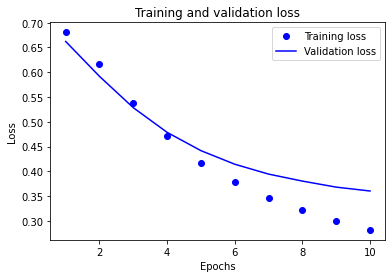

In [20]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

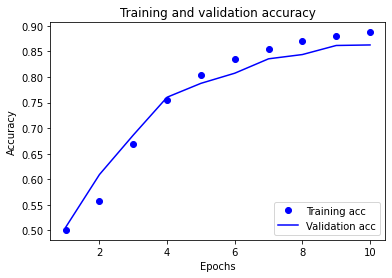

In [21]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.